# Ex 2: Manipulating Spectra Part 2 - `Spectra`

## Notebook Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]

import numpy as np
from scipy.integrate import quad

import darkhistory.physics as physics
import darkhistory.spec.spectools as spectools
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra

## `Spectra` Class - Introduction

The `Spectra` class is simply a collection of `Spectrum` objects. The main use of `Spectra` is as a list of spectra produced by the same process at different redshifts. It is the parent class of `TransFuncAtEnergy` and `TransFuncAtRedshift`, which are useful classes for transfer functions described in a later example. 

To demonstrate how to use this class, consider the photon spectrum produced by a massive dark matter particle $\phi$ decaying into an electron pair from a two-body decay + FSR process, given approximately by (see Essig et al. 1309.4091):

$$ \frac{dN_{\phi \to e^+ e^- \gamma}}{dE} \simeq \frac{2\alpha_{\text{EM}}}{\pi E_\gamma} \left[1 - \frac{2E_\gamma}{m_\phi} + \left(1 - \frac{2E_\gamma}{m_\phi} + \frac{2E_\gamma^2}{m_\phi^2} \right) \log \left( \frac{1 - 2E_\gamma/m_\phi}{m_e^2/m_\phi^2} \right) \right] $$

with $0 < E_\gamma < m_\phi/2$. This spectrum is per decay. For simplicity, we consider this process during the cosmic dark ages, where the dark matter density was uniform, and that the branching ratio into this process is 100%. We will also not concern ourselves with the overall normalization of this spectrum. 

We will again use `spec.spectools.discretize` to create `Spectrum` objects from this analytic spectrum, taking $m_\phi = $ 2 TeV. First, let's produce one spectrum and check it against the analytic expression. We will use a highly non-uniform binning to capture the threshold behavior near $E_\gamma = m_\phi/2$. 

In [3]:
def phi_decay_FSR(eng):
    m_phi = 2000
    m_e = 0.511e-3
    r = eng/m_phi
    r_e = m_e/m_phi
    if eng < m_phi/2:
        return (
            (2/137)/(np.pi*eng)*(1 - 2*r + (1 - 2*r + 2*r**2))
            *np.log((1 - 2*r)/r_e**2)
        )
    else: 
        return 0

eng = 1000-10**np.arange(-7,3,0.005)
eng = eng[::-1]
discrete_FSR = spectools.discretize(phi_decay_FSR, eng)

[100.0, 2000.0, 1e-06, 1]

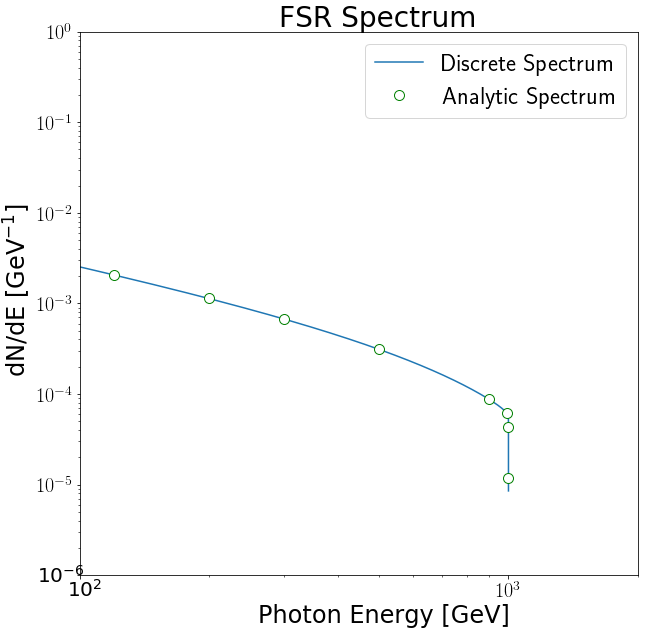

In [4]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

discrete_spec, = plt.plot(
    discrete_FSR.eng, discrete_FSR.dNdE, label='Discrete Spectrum'
)

eng_analytic = np.array([120, 200, 300, 500, 
                         900, 990, 999.99, 999.99999999])
dNdE_analytic = np.array([phi_decay_FSR(eng) for eng in eng_analytic])

analytic_spec, = plt.plot(
    eng_analytic, dNdE_analytic, 'go', marker='o', markersize='10', 
    markerfacecolor='w',
    label='Analytic Spectrum'
)

plt.legend(handles=[discrete_spec, analytic_spec], 
           fontsize=24)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('FSR Spectrum', fontsize=28)
plt.xlabel('Photon Energy [GeV]',fontsize=24)
plt.ylabel('dN/dE [GeV$^{-1}$]',fontsize=24)
plt.axis([1e2, 2e3, 1e-6, 1])

To create a `Spectra` object, we first create a list of `Spectrum` objects before calling the constructor. Here, we pass a list containing a single element at $1+z = 1000$, and then append `Spectrum` objects to the `Spectra` using `self.append`. We will append the same spectrum to it repeatedly, but with different redshifts `rs` and normalized by `1000/rs**3` so that we are now storing $dN/(dE \, dV)$: DM decays are diluted by a factor of `rs**3` as the universe expands.

In [5]:
spec_to_append = spectools.discretize(phi_decay_FSR, eng)
spec_to_append.rs = 1000
spectra_FSR = Spectra([spec_to_append])

for rs in 1000/(2+np.arange(9)):
    spec_to_append = spectools.discretize(phi_decay_FSR, eng)/(1000**3/rs**3)
    spec_to_append.rs = rs
    spectra_FSR.append(spec_to_append)

## `Spectra` - Attributes and Operations

The `Spectra` attributes are similar to `Spectrum`. `self.eng` and `self.rs` give the energy and redshift abscissa respectively. Note that all of the `Spectrum` objects must share the same energy abscissa to be stored in the same `Spectra` object. Use `Spectrum.rebin` to rebin `Spectrum` objects into the same abscissa where necessary. 

To get a 2D array of the raw values, indexed by `(eng, rs)`, use `self.grid_values`. 

As with `Spectrum`, we can add two `Spectra` objects, add a scalar to a `Spectra`, and likewise multiply two `Spectra` or multiply by a scalar. 

To access individual `Spectrum` objects, it is possible to get them by specifying an index, as if the `Spectra` object were a list. 

## `Spectra` - Plotting

`Spectra` objects are easy to plot using `self.plot`. They can be plotted at any arbitrary redshift, with the result obtained by interpolation over log of the redshift. Plotting arguments can be passed as keyword arguments. Individual `Spectrum` objects can also be plotted in a number of ways using the keyword `ind` and `indtype`. See documentation for more details.

[100.0, 2000.0, 1e-07, 0.01]

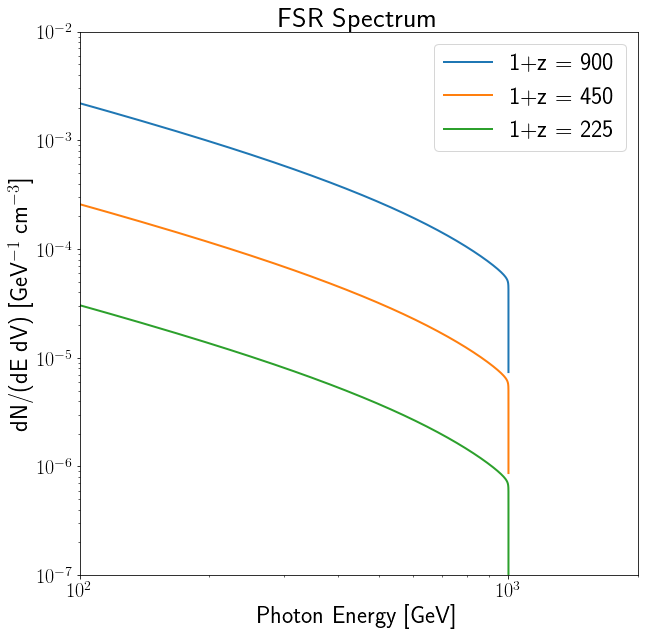

In [6]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

rs_to_plot = np.array([900, 450, 225])
spectra_plot = spectra_FSR.plot(ax, ind=rs_to_plot, indtype='rs', linewidth=2)

plt.legend(spectra_plot, ('1+z = 900','1+z = 450', '1+z = 225'), 
           fontsize=24)


ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('FSR Spectrum', fontsize=28)
plt.xlabel('Photon Energy [GeV]',fontsize=24)
plt.ylabel('dN/(dE dV) [GeV$^{-1}$ cm$^{-3}$]',fontsize=24)
plt.axis([1e2, 2e3, 1e-7, 1e-2])

## `Spectra` - Integration over each Spectrum

Integration over each spectrum can be done using `self.integrate_each_spec`, with the result being an `ndarray`. There are many reasons to perform an integration over each spectrum; here, we will show only a trivial example, integrating over the spectrum to get the total number. To do this, we use `self.integrate_each_spec` with a weight given by $E \, d \log E$. 

In [7]:
log_bin_width = spectools.get_log_bin_width(spectra_FSR.get_eng())
print('Total number of particles in each spectrum by integrate_each_spec: ')
print(spectra_FSR.integrate_each_spec(spectra_FSR.get_eng() * log_bin_width))
print('Total number of particles in each spectrum by Spectrum.totN(): ')
print(np.array([spec.totN() for spec in spectra_FSR]))

Total number of particles in each spectrum by integrate_each_spec: 
[ 1.00996347  0.12624543  0.03740605  0.01578068  0.00807971  0.00467576
  0.0029445   0.00197258  0.00138541  0.00100996]
Total number of particles in each spectrum by Spectrum.totN(): 
[ 1.00996347  0.12624543  0.03740605  0.01578068  0.00807971  0.00467576
  0.0029445   0.00197258  0.00138541  0.00100996]


## `Spectra` - Summing Spectra

It is frequently useful to add the spectra in a `Spectra` object up in some way. Here, we want to determine the spectrum of photons that would be observed from $\phi \to e^+e^-\gamma$ through FSR at the last redshift stored in `spectra_FSR`. The DM decays at each redshift, producing a $dN/(dE \, dV)$ stored in `spectra_FSR`. This spectrum is given *per decay*; the total spectrum needs to be re-weighted by the number of decays that occur within a redshift bin. Ignoring overall normalization once again, this means reweighting by a factor of

$$ \Delta t = \frac{dt}{d(1+z)} (1+z) \times \Delta \log (1+z)$$

In [8]:
rs_array = spectra_FSR.get_rs()
rs_log_bin_width = np.abs(spectools.get_log_bin_width(rs_array))
weight = physics.dtdz(rs_array)*rs_array*rs_log_bin_width
weight /= weight[-1]

To obtain the spectrum that would be observed at the last redshift, the spectrum at each redshift must first be redshifted down to the last redshift. Then, the spectra in `spectra_FSR` are added up, weighted by `weight`, to obtain the (un-normalized) photon spectrum that we would observe. 

In [9]:
for spec in spectra_FSR.spec_arr:
    spec.redshift(spectra_FSR.get_rs()[-1]) 

In [10]:
spectra_FSR.get_rs()

array([ 100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.])

[30.0, 2000.0, 1e-06, 0.01]

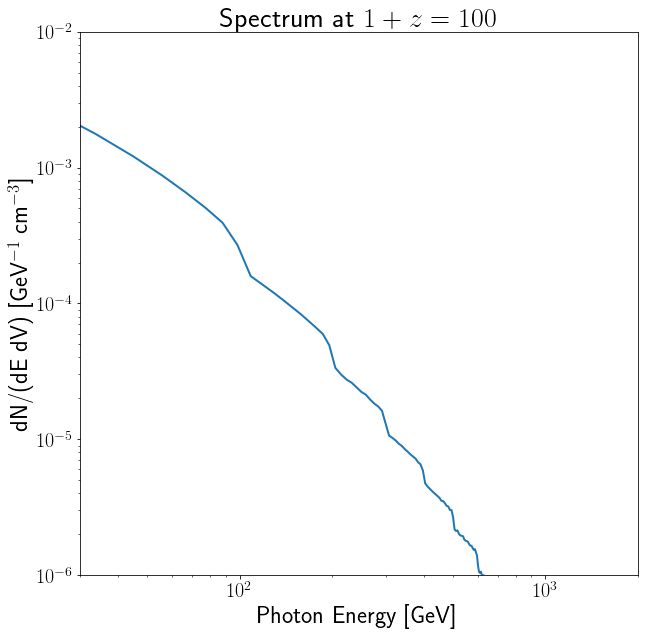

In [11]:
obs_spec = spectra_FSR.sum_specs(weight)

ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

spectra_plot, = plt.plot(spectra_FSR.get_eng(), obs_spec, linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Spectrum at $1+z = 100$', fontsize=28)
plt.xlabel('Photon Energy [GeV]',fontsize=24)
plt.ylabel('dN/(dE dV) [GeV$^{-1}$ cm$^{-3}$]',fontsize=24)
plt.axis([3e1, 2e3, 1e-6, 1e-2])